# Putting It All Together: A Realistic Example

In this section we're going to work through a realistic example of a deep learning workflow. We'll be working with a smallish dataset featuring different kinds of flowers from Kaggle. 
We're going to apply data augmentation to synthetically expand the size of our dataset.
(We are going to modify the data to expand the dataset)

And we'll attempt transfer learning using networks pretrained on the ImageNet dataset, which includes some flower species 
already.
(Transfer learning is used here at 

In [1]:
# All of this should look familiar from previous notebooks:
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image, ImageOps

from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical


# Return an image padded to be square with the specified background size
# default is black.
def square_image(image, background_color=(0, 0 , 0)):
    width, height = image.size
    if width == height:
        result = image
    elif width > height:
        result = Image.new(image.mode, (width, width), background_color)
        result.paste(image, (0, (width - height) // 2))
    else:
        result = Image.new(image.mode, (height, height), background_color)
        result.paste(image, ((height - width) // 2, 0))

    return result

# Our function to load an image from a path and fix it up, but 
# modified slightly to accomodate MobileNetV2.
def load_maintain_aspect_ratio(input_image_path, target_size):
    image = Image.open(input_image_path)
    image = square_image(image).resize(target_size)
    
    # Get the image data as a numpy array.
    image = np.array(image.getdata()).reshape(image.size[0], image.size[1], 3)
    
    # The preprocess function from MobileNetV2
    # It expects a numpy array with RGB values between 0-255
    return preprocess_input(image)


# Our recurring plot function.
def plot_training_history(history, model):
    figure = plt.figure()

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.tight_layout()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.tight_layout()

    figure.tight_layout()
    plt.show()

In [3]:
# Some constants:
# 224x224 is MobileNetV2's default, so lets stick with it
image_size = 224
batch_size = 32
validation_split = 0.2

# Start small, for the sake of learning speed.
num_epochs = 5

# The dataset is too large to reasonably redistribute as part of this repository, so you will
# have to download it separately from: https://www.kaggle.com/alxmamaev/flowers-recognition/

# The download as a flowers folder, this variable should point to the 
# loccation of that folder. Inside that folder there should be 5 folders
# each named for the type of flower.
flower_dataset_directory = './flowers/'

# The image classes
classes = {
    'daisy': 0, 
    'dandelion': 1, 
    'rose': 2,
    'sunflower': 3,
    'tulip': 4
}

# Process all of the images into an array
images = []
labels = []
for subdir in classes.keys():
    current_location = os.path.join(flower_dataset_directory, subdir)
    print(f'Processing {subdir}')
    sub_dir_count = 0
    for file in os.listdir(current_location):
        try:
            image = load_maintain_aspect_ratio(os.path.join(current_location, file), (image_size, image_size))
            images.append(image)
            labels.append(classes[subdir])
            sub_dir_count += 1
        except:
            print(f'Failed to load image: {subdir}/{file}. Ignored it.')
    
    print(f'Found {sub_dir_count} images of type {subdir}')

# Just double check.
assert len(images) == len(labels)

# This is a little bit crude, but we'll just randomly select each image/label pair
# to be in the validation set based on our validation split. We could take greater
# care here to ensure that the right amount are represented from each class
# but it will probably be okay...
x_train = []
y_train = []

x_validation = []
y_validation = []

for image, label in zip(images, labels):
    if np.random.random() > validation_split:
        x_train.append(image)
        y_train.append(label)
    else:
        x_validation.append(image)
        y_validation.append(label)

# Properly format the images into a np array
x_train = np.array(x_train)
x_validation = np.array(x_validation)

# Make the labels one-hot encoded:
y_train = to_categorical(y_train, len(classes))
y_validation = to_categorical(y_validation, len(classes))
            
print(f'Loaded {len(images)}')
print(f'Training size: {len(x_train)}, validation size: {len(x_validation)}')

Processing daisy
Found 769 images of type daisy
Processing dandelion
Failed to load image: dandelion/flickr.py. Ignored it.
Failed to load image: dandelion/flickr.pyc. Ignored it.
Failed to load image: dandelion/run_me.py. Ignored it.
Found 1052 images of type dandelion
Processing rose
Found 784 images of type rose
Processing sunflower
Found 734 images of type sunflower
Processing tulip
Found 984 images of type tulip
Loaded 4323
Training size: 3470, validation size: 853


In [4]:
# Lots of possible augmentation to the training data
# hopefully allowing us to avoid overfitting.

# Note, we're not using ZCA or normalization because the MobileNet's
# provided preprocess image function performs this kind of transformation
# with respect to the data it was pretrained on.
train_generator = ImageDataGenerator(    
    rotation_range=360,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=10, 
    zoom_range=0.5, 
    fill_mode='constant', 
    cval=0.0
)

# Don't transform the validation images.
validation_generator = ImageDataGenerator()

# Fit them both, best practice
train_generator.fit(x_train)
validation_generator.fit(x_validation)

(3470, 224, 224, 3)
(853, 224, 224, 3)
(3470, 5)
(853, 5)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


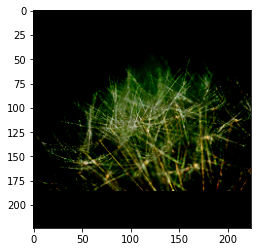

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


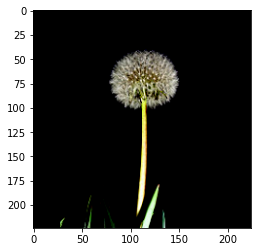

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


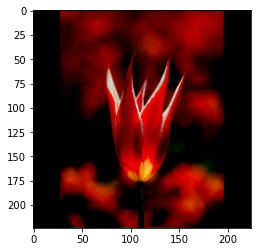

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


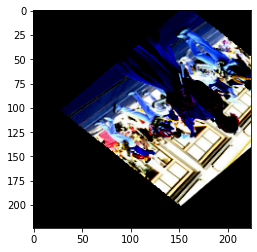

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


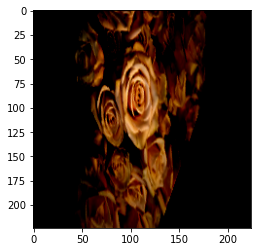

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


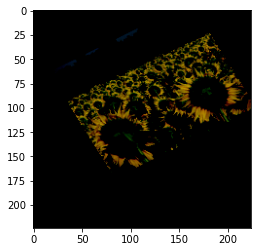

In [5]:
# Lets do some sanity checking:
print(x_train.shape)
print(x_validation.shape)
print(y_train.shape)
print(y_validation.shape)

# View a couple, validations are never augmented
for _ in range(3):
    plt.imshow(next(validation_generator.flow(x_validation))[0])
    plt.show()
    
# But training data is
for _ in range(3):
    plt.imshow(next(train_generator.flow(x_train))[0])
    plt.show()

9412608/9406464 [==============================] - 5s 0us/step
Tensor("out_relu/Identity:0", shape=(None, 7, 7, 1280), dtype=float32)
Epoch 1/5
108/108 [==============================] - 124s 1s/step - loss: 0.8906 - accuracy: 0.6495 - val_loss: 0.6130 - val_accuracy: 0.7704
Epoch 2/5
108/108 [==============================] - 106s 982ms/step - loss: 0.5887 - accuracy: 0.7871 - val_loss: 0.5168 - val_accuracy: 0.8161
Epoch 3/5
108/108 [==============================] - 102s 946ms/step - loss: 0.5162 - accuracy: 0.8127 - val_loss: 0.4897 - val_accuracy: 0.8353
Epoch 4/5
108/108 [==============================] - 94s 871ms/step - loss: 0.4766 - accuracy: 0.8278 - val_loss: 0.4568 - val_accuracy: 0.8401
Epoch 5/5
108/108 [==============================] - 131s 1s/step - loss: 0.4660 - accuracy: 0.8304 - val_loss: 0.5066 - val_accuracy: 0.8065


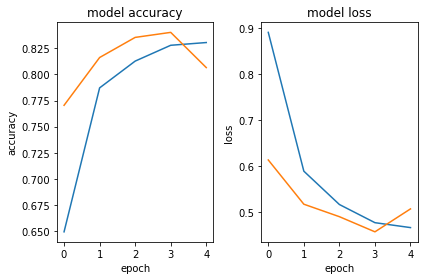

In [6]:
# Loading our pretrained mobilenet 
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

# Make a very simple new classifier
old_top = base_model.output
print(base_model.output)

old_top = GlobalAveragePooling2D()(old_top)

new_top = Dense(len(classes), activation='softmax')(old_top)
model = Model(inputs=base_model.input, outputs=new_top)

# We have a small amount of data, but the data is pretty similar
# to imagenet, which does train on many flower images, so we can
# expect the existing weights to be pretty good. Freeze all. 
for layer in base_model.layers:
    layer.trainable = False

# Go for it!
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_generator.flow(x_train, y_train, batch_size=batch_size), 
                    steps_per_epoch=len(x_train) // batch_size, 
                    epochs=num_epochs,
                    validation_data=validation_generator.flow(x_validation, y_validation),
                    validation_steps=len(x_validation) // batch_size
)

plot_training_history(history, model)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/5
108/108 [==============================] - 105s 975ms/step - loss: 0.5597 - accuracy: 0.7963 - val_loss: 0.3888 - val_accuracy: 0.8582
Epoch 2/5
108/108 [==============================] - 104s 966ms/step - loss: 0.5015 - accuracy: 0.8126 - val_loss: 0.3816 - val_accuracy: 0.8570
Epoch 3/5
108/108 [==============================] - 105s 972ms/step - loss: 0.4557 - accuracy: 0.8372 - val_loss: 0.3775 - val_accuracy: 0.8582
Epoch 4/5
108/108 [==============================] - 103s 958ms/step - loss: 0.4575 - accuracy: 0.8358 - val_loss: 0.3712 - val_accuracy: 0.8618
Epoch 5/5
108/108 [==============================] - 105s 971ms/step - loss: 0.4448 - accuracy: 0.8378 - val_loss: 0.3549 - val_accuracy: 0.8630


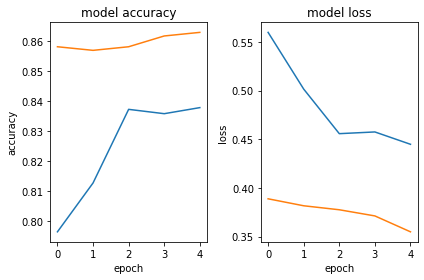

In [6]:
# Things are going great! Lets unfreeze some of our model's layers and see if "forgetting" 
# some of the stuff our network learned about dogs, buildings, and waterbottles can
# improve our results further... 

# This number was chosen specifically for MobileNetV2, it is the 
# start of the 15th block. 
for layer in model.layers[134:]:
    layer.trainable = True

# Recompile to ensure the layers get set to trainable
# Based on previous experiments with fine-tuning, lets use an extra slow learning rate and SGD.
model.compile(optimizer=SGD(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit_generator(train_generator.flow(x_train, y_train, batch_size=batch_size), 
                    steps_per_epoch=len(x_train) // batch_size, 
                    epochs=num_epochs,
                    validation_data=validation_generator.flow(x_validation, y_validation),
                    validation_steps=len(x_validation) // batch_size
)

plot_training_history(history, model)

Right on, things still look good. Validation scores have mostly plateaued and at least over the final few epochs training scores seem to as well... But overall it looks like fine-tuning may be helping a bit. We know from experience that it can take a LOT of tuning at this slow rate to really improve so lets keep training and see what happens.

Epoch 1/15
108/108 [==============================] - 104s 958ms/step - loss: 0.4255 - accuracy: 0.8414 - val_loss: 0.3583 - val_accuracy: 0.8690
Epoch 2/15
108/108 [==============================] - 107s 995ms/step - loss: 0.4226 - accuracy: 0.8520 - val_loss: 0.3543 - val_accuracy: 0.8678
Epoch 3/15
108/108 [==============================] - 104s 959ms/step - loss: 0.4007 - accuracy: 0.8543 - val_loss: 0.3470 - val_accuracy: 0.8738
Epoch 4/15
108/108 [==============================] - 106s 980ms/step - loss: 0.3944 - accuracy: 0.8575 - val_loss: 0.3403 - val_accuracy: 0.8726
Epoch 5/15
108/108 [==============================] - 103s 956ms/step - loss: 0.4061 - accuracy: 0.8561 - val_loss: 0.3340 - val_accuracy: 0.8726
Epoch 6/15
108/108 [==============================] - 101s 938ms/step - loss: 0.3911 - accuracy: 0.8566 - val_loss: 0.3279 - val_accuracy: 0.8750
Epoch 7/15
108/108 [==============================] - 99s 919ms/step - loss: 0.3745 - accuracy: 0.8697 - val_loss: 0.3287 - 

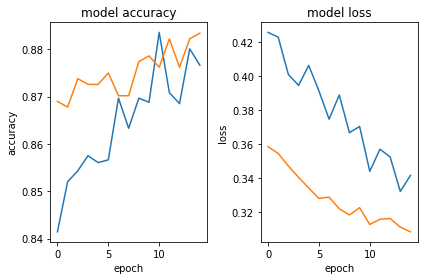

In [7]:
history = model.fit(train_generator.flow(x_train, y_train, batch_size=batch_size), 
                    steps_per_epoch=len(x_train) // batch_size, 
                    epochs=15,
                    validation_data=validation_generator.flow(x_validation, y_validation),
                    validation_steps=len(x_validation) // batch_size
)

plot_training_history(history, model)

Interesting! We see some small incremental improvement. A bit eratic at times, especially for a model without dropout,  but honestly we could probably continue to train here and see continued improvement. :)